<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/training_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Processing for Landuse Classification

In this lesson, we will use a sub-set of Landsat 9 satellite megapixel-based in the central part of the country.  We will prepare them for pixel-based classification using machine learning algorithms. The images were already radiometrically and atmospherically corrected.

We will train the machine learning models with four feature classes extracted from Google Earth imagery: (1) Home stage vegetation, (2) cropland, (3) Bare soil/Developed, and (4) water bodies. We used on-screen digitization in ArcMap to Create polygons representing members of these feature classes. First, we will convert the polygons to a 30 x 30-meter raster grid and then to a spatial points data frame. Next, we will extract values from the B2, B3, B4, B5, B6, and B7 bands and 30 m SRTM DEM and add them to the spatial point data frame we will use for training, validation, and testing the models. We will also use all these bands and DEM to create a prediction grid point data set for predicting land-use classes.

### Install rpy2

In [ ]:

!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Require R Package

In [5]:

%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Install R-packages

In [49]:
%%R
.libPaths('drive/My Drive/R')
library (terra)
library (tidyterra)
library(sf)
library(raster)
library(rgdal)
library(luna)
library(geodata)
library(tidyverse)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(tmap)
library(tmaptools)
library(gridExtra)

### Data

In [6]:
%%R
bd<-st_read("/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp")
aoi<-st_read("/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp")
aoi_01<-st_read("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/AOI_1.shp")
ls<-rast("/content/drive/MyDrive/Data/DSM_AOI/Landsat/Level_01/Scene/LC08_L1TP_137044_20230203_20230209_02_T1/LC08_L1TP_137044_20230203_20230209_02_T1_B1.TIF")

Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 0 features and 1 field
Bounding box:  xmin: NA ymin: NA xmax: NA ymax: NA
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 0 features and 1 field
Bounding box:  xmin: NA ymin: NA xmax: NA ymax: NA
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading layer `AOI_1' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/AOI_1.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 150901.7 ymin: 2558579 xmax: 180901.7 ymax: 2588579
Projected CRS: WGS 84 / UTM zone 46N + unknown


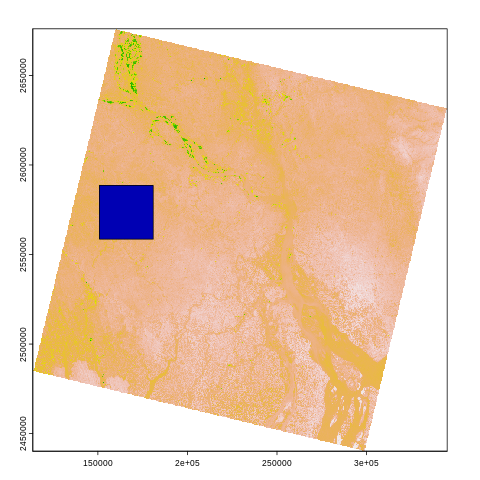

In [7]:
%%R
#plot(bd, main= "Landsat 8 Scene: 137/44 and AOI")
plot(ls, legend =F)
plot(aoi_01, add=TRUE)

### Import Raster Images

In [57]:
%%R
multi<-raster::stack("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/multiband_2_7_aoi_1.tif")
dem<-raster::raster('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/dem_aoi_1.tif')
names(dem)<-"dem"

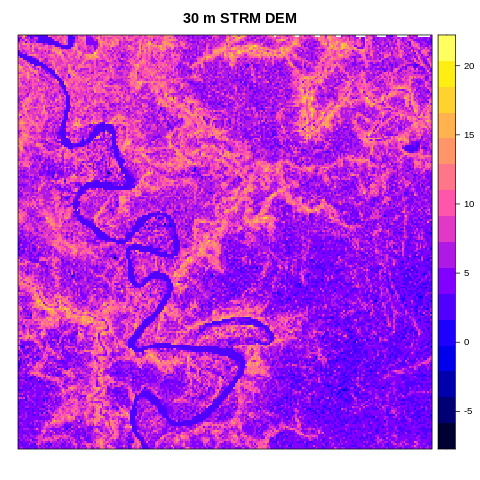

In [112]:
%%R
spplot(dem, main="30 m STRM DEM")

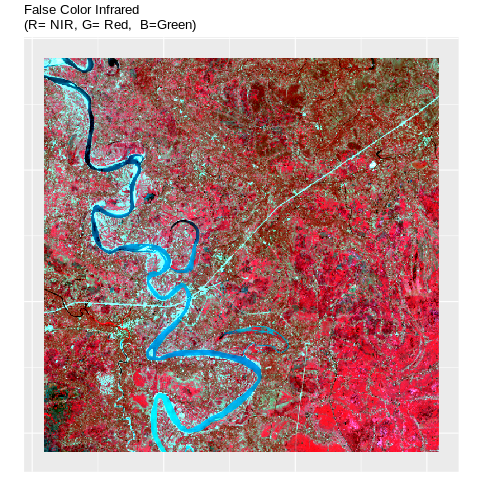

In [110]:
%%R
# False Color image
ggRGB(multi, r=4, g=3, b=2, stretch = "lin")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
  ggtitle("False Color Infrared\n(R= NIR, G= Red,  B=Green)")


## Training Data Processing

### Convert training polygon to raster

Before converting the land use polygon file to raster, we will extract the extent of any band of Landsat 9 to set the raster extent. We use B2 to define raster extent.

In [58]:
%%R
poly <- st_read('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/train_poly_aoi_1.shp')
poly

Reading layer `train_poly_aoi_1' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/train_poly_aoi_1.shp' 
  using driver `ESRI Shapefile'
replacing null geometries with empty geometries
Simple feature collection with 97 features and 1 field (with 1 geometry empty)
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 151135 ymin: 2558741 xmax: 180411.3 ymax: 2587557
Projected CRS: WGS 84 / UTM zone 46N + unknown
Simple feature collection with 97 features and 1 field (with 1 geometry empty)
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 151135 ymin: 2558741 xmax: 180411.3 ymax: 2587557
Projected CRS: WGS 84 / UTM zone 46N + unknown
First 10 features:
   Id                       geometry
1   1 POLYGON ((167583.4 2575164,...
2   1 POLYGON ((165182.3 2573127,...
3   1 POLYGON ((164196.7 2575210,...
4   1 POLYGON ((162682 2571758, 1...
5   1 POLYGON ((160896.9 2584646,...
6   1 POLYGON ((161885.7 2584652,...
7 

In [111]:
%%R
extent<-ext(multi[[2]])


In [60]:
%%R
# create an empty raster
r <- rast(extent, resolution = 30)
rp <- rasterize(poly, r, 'Id')


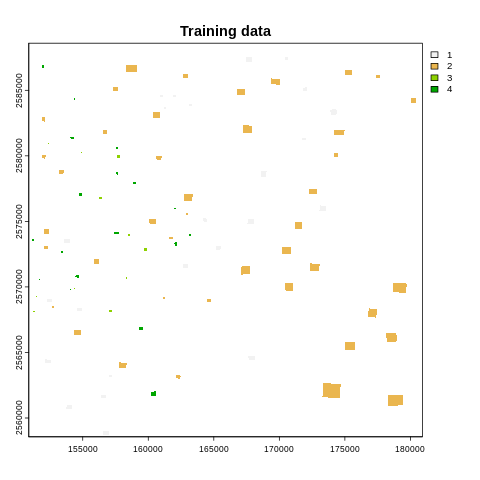

In [61]:
%%R
plot(rp, main="Training data")

### Convert to Spatial Point dataframe

In [62]:
%%R
rp.df <- as.data.frame(rp, xy = TRUE)
str(rp.df)

'data.frame':	16415 obs. of  3 variables:
 $ x : num  170400 170430 170460 170490 170520 ...
 $ y : num  2587530 2587530 2587530 2587530 2587530 ...
 $ Id: int  1 1 1 1 1 1 1 1 1 1 ...


In [26]:
%%R
levels(as.factor(rp.df$Id))

[1] "1" "2" "3" "4"


In [63]:
%%R
xy <- rp.df[,c(1,2)]
point.SPDF<- SpatialPointsDataFrame(coords = xy,
                                data=rp.df,
                                proj4string = CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs"))

### Extract bands  and dem values to training points

In [80]:
%%R
point.bands <- raster::extract(multi, point.SPDF)
point.dem <- raster::extract(dem, point.SPDF)
point.mf<-cbind(rp.df,point.bands, point.dem)
colnames(point.mf)[10]<-"dem"
head(point.mf)
length(point.mf$x)

[1] 16415


### Add class ID and save as a CSV file

In [93]:
%%R
# Import lnaduse ID file
ID<-read.csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/landuse_id.csv")
# Join with point data frame
point.gt<-merge(point.mf, ID, by="Id", type="inner")
head(point.gt)
write_csv(point.gt, "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/point_data.csv")

## Grid Data Processing

First, we will empty point data frame, will use Band B2

In [94]:
%%R
multi

class      : RasterStack 
dimensions : 1001, 1001, 1002001, 6  (nrow, ncol, ncell, nlayers)
resolution : 30, 30  (x, y)
extent     : 150885, 180915, 2558565, 2588595  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=46 +datum=WGS84 +units=m +no_defs 
names      :    B2,    B3,    B4,    B5,    B6,    B7 
min values :  7418,  8493,  7597,  8822,  7904,  7622 
max values : 14226, 16173, 17473, 24870, 26354, 24278 



In [97]:
%%R
grid.point <- data.frame(rasterToPoints(multi[[1]]))
# Remove B2 column, just keep x & y
grid.point$B2<-NULL
# define co-ordinates and projection
coordinates(grid.point) <- ~x + y
projection(grid.point) <- CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs")

### Extract all bands and dem values to grird locations

In [104]:
%%R
bands.grid<- raster::extract(multi, grid.point, df=TRUE, method='simple')
dem.grid<- raster::extract(dem, grid.point, df=TRUE, method='simple')
grid<-cbind(as.data.frame(grid.point),bands.grid, dem.grid)
grid[,10]<-NULL
write_csv(grid,"/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data.csv" )
head(grid)

       x       y ID   B2    B3    B4    B5    B6    B7       dem
1 150930 2588550  1 9289 10661 10019 18168 14338 11357  9.827662
2 150960 2588550  2 9333 10657 10261 17364 14709 11819 14.767797
3 150990 2588550  3 9526 10988 10927 16623 15744 13262  2.985770
4 151020 2588550  4 9635 11020 11013 16162 15363 12782  2.595814
5 151050 2588550  5 9532 10766 10420 16683 15173 12286  2.571604
6 151080 2588550  6 9615 10925 10522 17598 15571 12710  8.822142
